In [1]:
import torch
import torch.nn as nn
#!pip install torchtext
from torchtext import data
from torchtext import datasets
import torch.optim as optim
# Install pandas and numpy for datasets
import time
import pandas as pd
import numpy as np
import csv
import json
# Install spacy for NLP
#!pip install spacy
import spacy
!python -m spacy download en_core_web_sm
import re
# Install pyplot for visualize
import matplotlib.pyplot as plt
import pickle

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [2]:
####Section 1 Data Cleaning####
# Read the data we use
train = pd.read_csv('large-noisy-train.csv')
train_clean = pd.read_csv('large-clean-train.csv')

In [3]:
# look at a few rows of the train file.
train

,overall,reviewText,summary,vote,category,sentiment
0,2,Koi scrub pants fit better.,Runs small,0.0,fashion,bad
1,2,"Run big, the legs are EXTREMELY baggy. Had to ...",Two Stars,0.0,fashion,bad
2,3,"It's good for those who wish to save money, ok...",It's good for those who wish to save money,0.0,beauty,ok
3,3,Item runs a little on the large size. I was d...,"Medium size, is more like large.",0.0,fashion,ok
4,2,THIS IS A COPY OF A REAL ON... ITS NOT THE RIG...,Two Stars,0.0,fashion,bad
...,...,...,...,...,...,...
53755,5,Best Sun Hat Ever! Have in 2 Colors!,Five Stars,0.0,fashion,good
53756,5,This battery trimmer works fine for me and for...,Works fine for me!,0.0,beauty,good
53757,3,"Great pants, but no pockets............That's...",Super comfortable,0.0,fashion,ok
53758,1,Not what i wanted only one in package and does...,One Star,0.0,appliance,bad


In [4]:
# Count the row which contained the missing value
missing_values_count = train.isnull().sum()
missing_values_count[0:10]

overall         0
reviewText    520
summary         0
vote          520
category        0
sentiment       0
dtype: int64

In [5]:
# Remove the missing value
new_train = train.dropna(axis = 0, how ='any')
new_train

,overall,reviewText,summary,vote,category,sentiment
0,2,Koi scrub pants fit better.,Runs small,0.0,fashion,bad
1,2,"Run big, the legs are EXTREMELY baggy. Had to ...",Two Stars,0.0,fashion,bad
2,3,"It's good for those who wish to save money, ok...",It's good for those who wish to save money,0.0,beauty,ok
3,3,Item runs a little on the large size. I was d...,"Medium size, is more like large.",0.0,fashion,ok
4,2,THIS IS A COPY OF A REAL ON... ITS NOT THE RIG...,Two Stars,0.0,fashion,bad
...,...,...,...,...,...,...
53755,5,Best Sun Hat Ever! Have in 2 Colors!,Five Stars,0.0,fashion,good
53756,5,This battery trimmer works fine for me and for...,Works fine for me!,0.0,beauty,good
53757,3,"Great pants, but no pockets............That's...",Super comfortable,0.0,fashion,ok
53758,1,Not what i wanted only one in package and does...,One Star,0.0,appliance,bad


In [6]:
# Check the missing values in new dataframe
missing_values_count = new_train.isnull().sum()
missing_values_count[0:10]

overall       0
reviewText    0
summary       0
vote          0
category      0
sentiment     0
dtype: int64

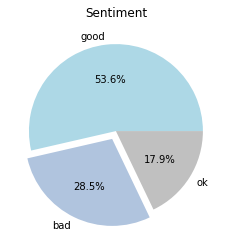

In [7]:
# Plot the sentiment and vote columns
sentiment = new_train['sentiment'].value_counts()
explode = (0, 0.1, 0) 
my_colors = ['lightblue','lightsteelblue','silver']

plt.pie(sentiment,labels=sentiment.index,colors = my_colors,explode =explode, autopct='%1.1f%%')
plt.title('Sentiment')
plt.show()

In [28]:
# Export dataframe to Json File
#dataFolder = '/Users/dmy/Downloads/' # keep all your data files in a single folder
new_train.to_json ('/Users/dmy/Downloads/new_train.json',orient='records',lines = True)

In [29]:
#### Section 2: Spacy (optional) ###
nlp = spacy.load('en_core_web_sm')

In [30]:
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [37]:
#### Section 2: Tokenizer ###
# create a tokenizer function
def tokenizer(text): 
    # return a list of words. 
    doc = nlp(text)
    result = []
    for token in doc:
        ent = nlp.vocab[token.text]
        if ent.is_stop == False:
            result.append(token.text)
    return result

In [38]:
TEXT = data.Field(tokenize = tokenizer, lower=True, include_lengths = True)
LABEL = data.LabelField(dtype = torch.long)
fields = {'reviewText': ('t', TEXT), 'sentiment': ('l', LABEL)}

In [42]:
import warnings
warnings.filterwarnings("ignore")

In [39]:
#### Section 4: Datasets ###
dataFolder = '/Users/dmy/Downloads'
train_data, valid_data, test_data = data.TabularDataset.splits(
                                        path = dataFolder, 
                                        train = 'new_train.json', # json file
                                        validation = 'large-clean-val.json',# json file
                                        test = 'large-clean-val.json',# json file
                                        format = 'json', # json file
                                        fields = fields
)

In [40]:
#### Section 5: Vocabulary ###

# You can use GloVe vocabulary to train your model faster towards convergence or build up your own embeddings. 
# If you are not using the GloVe embeddings, you will need to comment out the embedding weight transfer to model in 
# Section 9

MAX_VOCAB_SIZE = 25_000

#Local vocabulary
# TEXT.build_vocab(train_data, max_size = MAX_VOCAB_SIZE)
# LABEL.build_vocab(train_data)

#GloVe vocabulary
TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)
LABEL.build_vocab(train_data)

# Check if it worked
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')
print(vars(train_data[0]))

Number of training examples: 53240
Number of testing examples: 30240
{'t': ['koi', 'scrub', 'pants', 'fit', 'better', '.'], 'l': 'bad'}


In [43]:
#### Section 6: Iterators ###
# Iterators organizes datasets into batches and feeds them into the model. In this skeletion, we use packed padded sequence
# to make sure that all the input data points are of the same size and they do not incur unnecessary computation. Read more 
# about packed padded sequence here: https://stackoverflow.com/questions/51030782/why-do-we-pack-the-sequences-in-pytorch
# For that, we need to sort the samples in each batch in decreasing order of number of words.

BATCH_SIZE = 32

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    sort = False, 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    sort_key = lambda x: len(x.t),
    device = device)

In [44]:
#### Section 7: Vanilla RNN ###

class VanillaRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        # Add your network's trainable layers here.
        self.rnn = nn.RNN(embedding_dim, 
                          hidden_dim, 
                          num_layers=n_layers, 
                          bidirectional=bidirectional, 
                          dropout=dropout)
    
        self.fc1 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text, text_lengths):
        
        #text = [sent len, batch size]
        
        #embedded = self.dropout(self.embedding(text))
        embedded = self.embedding(text)
        
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence. Clambing the lengths to avoid errors in some bugs
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.clamp(min=1, max=50))
        
        # now packed_embedded is the input to your model. You can do whatever you want to do from this point
        packed_output, hidden = self.rnn(packed_embedded)
        output = self.fc1(hidden[-1,:,:])

        return output


In [46]:
#### Section 8: Create your models ###
### A.Vanilla RNN
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 3
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model_Vanilla = VanillaRNN(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)

In [47]:
#### Section 9: Transfer pretrained weights for word embeddings from GloVe ###

### Vanilla RNN

pretrained_embeddings = TEXT.vocab.vectors
print(pretrained_embeddings.shape)
model_Vanilla.embedding.weight.data.copy_(pretrained_embeddings)

torch.Size([19173, 100])


tensor([[ 2.3726, -0.6803, -0.2791,  ..., -0.5009, -1.8414,  0.1553],
        [-1.5164,  1.2630, -1.1952,  ...,  1.0377,  0.6578, -0.4795],
        [-0.3398,  0.2094,  0.4635,  ..., -0.2339,  0.4730, -0.0288],
        ...,
        [-0.4945,  0.2124,  1.1757,  ...,  0.4568, -0.5195, -0.1314],
        [-2.2840, -0.0579, -1.1277,  ..., -0.6937, -2.4676, -0.9993],
        [ 0.8105,  0.2015,  1.5414,  ...,  0.6984, -1.0898, -2.1482]])

In [48]:
#### Section 10: Optimizer and Loss 
### Vanilla RNN
optimizer = optim.Adam(model_Vanilla.parameters())

#criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss()

model_Vanilla = model_Vanilla.to(device)
criterion = criterion.to(device)


In [49]:
def accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    predictedLabel = torch.argmax(torch.exp(preds), dim=1)
    correct = (predictedLabel == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [50]:
#### Section 11: Training process

def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        text, text_lengths = batch.t
        
        predictions = model(text, text_lengths).squeeze(1)
        
        loss = criterion(predictions, batch.l)
        
        acc = accuracy(predictions, batch.l)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [51]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text, text_lengths = batch.t
            
            predictions = model(text, text_lengths).squeeze(1)
            
            loss = criterion(predictions, batch.l)
            
            acc = accuracy(predictions, batch.l)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [52]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [66]:
#### Section 12: Train

t_vanilla = time.time()
loss_vanilla=[]
acc_vanilla=[]
val_acc_vanilla=[]
modelOutputName = 'vanilla-rnn.pt'

N_EPOCHS = 30

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model_Vanilla, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model_Vanilla, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_Vanilla.state_dict(), modelOutputName)
    loss_vanilla.append(train_loss)
    acc_vanilla.append(train_acc)
    val_acc_vanilla.append(valid_acc)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 3m 1s
	Train Loss: 0.220 | Train Acc: 92.57%
	 Val. Loss: 0.821 |  Val. Acc: 75.29%
Epoch: 02 | Epoch Time: 3m 6s
	Train Loss: 0.220 | Train Acc: 92.57%
	 Val. Loss: 0.821 |  Val. Acc: 75.29%
Epoch: 03 | Epoch Time: 3m 7s
	Train Loss: 0.220 | Train Acc: 92.58%
	 Val. Loss: 0.821 |  Val. Acc: 75.29%
Epoch: 04 | Epoch Time: 3m 40s
	Train Loss: 0.220 | Train Acc: 92.57%
	 Val. Loss: 0.821 |  Val. Acc: 75.29%
Epoch: 05 | Epoch Time: 4m 19s
	Train Loss: 0.220 | Train Acc: 92.57%
	 Val. Loss: 0.821 |  Val. Acc: 75.29%
Epoch: 06 | Epoch Time: 5m 7s
	Train Loss: 0.220 | Train Acc: 92.57%
	 Val. Loss: 0.821 |  Val. Acc: 75.29%
Epoch: 07 | Epoch Time: 4m 41s
	Train Loss: 0.220 | Train Acc: 92.57%
	 Val. Loss: 0.821 |  Val. Acc: 75.29%
Epoch: 08 | Epoch Time: 4m 35s
	Train Loss: 0.220 | Train Acc: 92.58%
	 Val. Loss: 0.821 |  Val. Acc: 75.29%
Epoch: 09 | Epoch Time: 4m 34s
	Train Loss: 0.220 | Train Acc: 92.58%
	 Val. Loss: 0.821 |  Val. Acc: 75.29%
Epoch: 10 | Epoch Time:

<function matplotlib.pyplot.show(*args, **kw)>

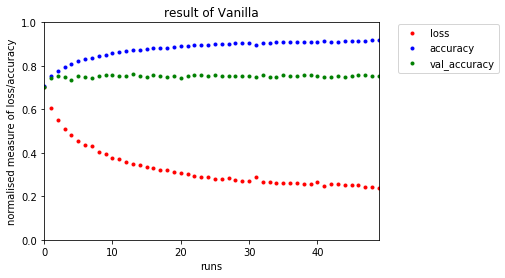

In [55]:
#### Section 13: Plots
plt.xlabel("runs")
plt.ylabel("normalised measure of loss/accuracy")
x_len=list(range(len(acc_vanilla)))
plt.axis([0, max(x_len), 0, 1])
plt.title('result of Vanilla')
loss=np.asarray(loss_vanilla)/max(loss_vanilla)
plt.plot(x_len, loss_vanilla, 'r.',label="loss")
plt.plot(x_len, acc_vanilla, 'b.', label="accuracy")
plt.plot(x_len, val_acc_vanilla, 'g.', label="val_accuracy")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.2)
plt.show

In [77]:
#### Section 7: Advanced Model:LSTM ###

class AdvancedModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        # Add your network's trainable layers here.
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
    
        
    def forward(self, text, text_lengths):
        
        #text = [sent len, batch size]
        
       # embedded = self.dropout(self.embedding(text))
        embedded = self.embedding(text)
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence. Clambing the lengths to avoid errors in some bugs
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.clamp(min=1, max=50))
        
        # now packed_embedded is the input to your model. You can do whatever you want to do from this point
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        output = self.fc1(hidden)
        output = self.dropout(self.fc2(output))
                
        #hidden = [batch size, hid dim * num directions]
            
        return output

In [78]:
#### Section 8: Create your models ###
### LSTM RNN
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 3
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model_LSTM = AdvancedModel(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)


In [79]:
#### Section 9: Transfer pretrained weights for word embeddings from GloVe ###
### B. LSTM RNN

pretrained_embeddings = TEXT.vocab.vectors
print(pretrained_embeddings.shape)
model_LSTM.embedding.weight.data.copy_(pretrained_embeddings)

torch.Size([19173, 100])


tensor([[ 2.3726, -0.6803, -0.2791,  ..., -0.5009, -1.8414,  0.1553],
        [-1.5164,  1.2630, -1.1952,  ...,  1.0377,  0.6578, -0.4795],
        [-0.3398,  0.2094,  0.4635,  ..., -0.2339,  0.4730, -0.0288],
        ...,
        [-0.4945,  0.2124,  1.1757,  ...,  0.4568, -0.5195, -0.1314],
        [-2.2840, -0.0579, -1.1277,  ..., -0.6937, -2.4676, -0.9993],
        [ 0.8105,  0.2015,  1.5414,  ...,  0.6984, -1.0898, -2.1482]])

In [80]:
#### Section 10: Optimizer and Loss 
### LSTM RNN
optimizer = optim.Adam(model_LSTM.parameters())

#criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss()

model_L = model_LSTM.to(device)
criterion = criterion.to(device)

In [81]:
#### Section 12: Train
### LSTM

t_LSTM = time.time()
loss_LSTM=[]
acc_LSTM=[]
val_acc_LSTM=[]
modelOutputName = 'LSTM-rnn.pt'

N_EPOCHS = 30

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model_LSTM, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model_LSTM, valid_iterator, criterion)
     
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_LSTM.state_dict(), modelOutputName)
    loss_LSTM.append(train_loss)
    acc_LSTM.append(train_acc)
    val_acc_LSTM.append(valid_acc)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\t Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 8m 53s
	 Train Loss: 0.628 | Train Acc: 73.70%
	 Val. Loss: 0.599 |  Val. Acc: 75.70%
Epoch: 02 | Epoch Time: 7m 16s
	 Train Loss: 0.508 | Train Acc: 79.12%
	 Val. Loss: 0.575 |  Val. Acc: 77.13%
Epoch: 03 | Epoch Time: 11m 54s
	 Train Loss: 0.428 | Train Acc: 82.98%
	 Val. Loss: 0.601 |  Val. Acc: 77.11%
Epoch: 04 | Epoch Time: 9m 25s
	 Train Loss: 0.345 | Train Acc: 86.38%
	 Val. Loss: 0.690 |  Val. Acc: 77.05%
Epoch: 05 | Epoch Time: 10m 22s
	 Train Loss: 0.261 | Train Acc: 90.10%
	 Val. Loss: 0.869 |  Val. Acc: 76.58%
Epoch: 06 | Epoch Time: 11m 4s
	 Train Loss: 0.185 | Train Acc: 93.13%
	 Val. Loss: 0.932 |  Val. Acc: 76.17%
Epoch: 07 | Epoch Time: 11m 17s
	 Train Loss: 0.124 | Train Acc: 95.41%
	 Val. Loss: 1.116 |  Val. Acc: 76.60%
Epoch: 08 | Epoch Time: 12m 10s
	 Train Loss: 0.081 | Train Acc: 97.06%
	 Val. Loss: 1.375 |  Val. Acc: 76.44%
Epoch: 09 | Epoch Time: 11m 45s
	 Train Loss: 0.059 | Train Acc: 97.89%
	 Val. Loss: 1.834 |  Val. Acc: 76.31%
Epoch

<function matplotlib.pyplot.show(*args, **kw)>

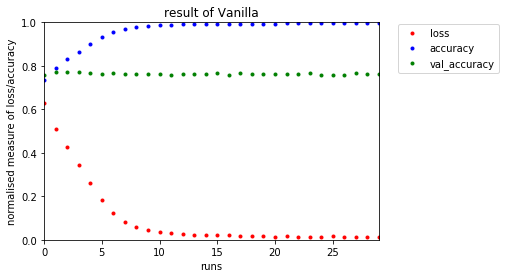

In [82]:
#### Section 13: Plots
#### LSTM
plt.xlabel("runs")
plt.ylabel("normalised measure of loss/accuracy")
x_len=list(range(len(acc_LSTM)))
plt.axis([0, max(x_len), 0, 1])
plt.title('result of Vanilla')
loss=np.asarray(loss_LSTM)/max(loss_LSTM)
plt.plot(x_len, loss_LSTM, 'r.',label="loss")
plt.plot(x_len, acc_LSTM, 'b.', label="accuracy")
plt.plot(x_len, val_acc_LSTM, 'g.', label="val_accuracy")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.2)
plt.show

### After comparing these two models, I found that the validation accuracy lines are almost straight. The possible reason is that the data size is not big enough. If we increase our data size, we could probably get a better result.